# Plotting results of GLOS QARTOD QC Tests

## RPS Group
### Bob Fratantonio and Jamie Schicho
### March 14, 2018

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
### Procedure
* Connect to GLOS OPeNDAP endpoints
* Get raw wave height data from stations of interest
* Plot raw data and QC'ed data for a series of QC tests

### Primary flags for QARTOD

    GOOD_DATA = 1
    UNKNOWN = 2
    SUSPECT = 3
    BAD_DATA = 4
    MISSING = 9

In [1]:
import psycopg2
import numpy as np
from urllib.parse import quote
import qc
import quantities as q
import pandas as pd
from io import StringIO
#from IPython import embed
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import folium
import netCDF4 as nc
from datetime import datetime, timedelta
import xarray as xr

In [2]:
def get_coordinates(bounding_box):
    """Create bounding box coordinates for the map."""
    coordinates = []
    coordinates.append([bounding_box[1], bounding_box[0]])
    coordinates.append([bounding_box[1], bounding_box[2]])
    coordinates.append([bounding_box[3], bounding_box[2]])
    coordinates.append([bounding_box[3], bounding_box[0]])
    coordinates.append([bounding_box[1], bounding_box[0]])
    return coordinates

### Connect to OPeNDAP Endpoints

In [3]:
Glos_url='http://tds.glos.us/thredds/dodsC/buoy_agg_standard_qc/'
station_ids=['45024','45022','45174','45170']  ##45014 has only 35 time steps and glerlwe13 doesn't have any data in the time range chosen (oct 22-oct 29)
                         ##45013,glerlwe8, glerlwe4, glerlwe2, and UMBIO have NaN values for 
                         #Significant Wave Height (October 2017) or no sig wave height variable
bbox=[[-93.186, 40.1956], [-74.992, 49.511]]


### Location Flag Plots

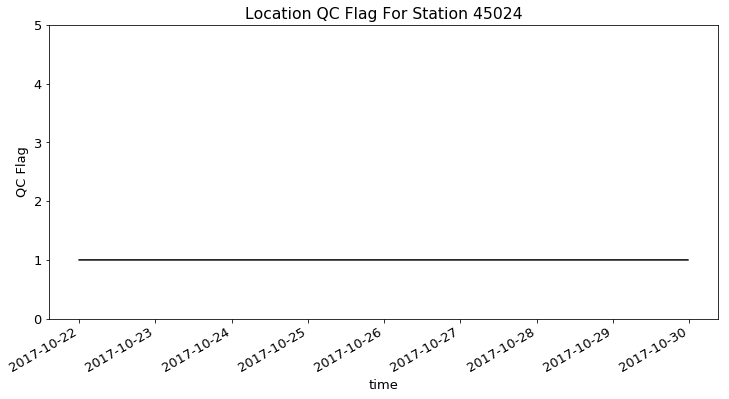

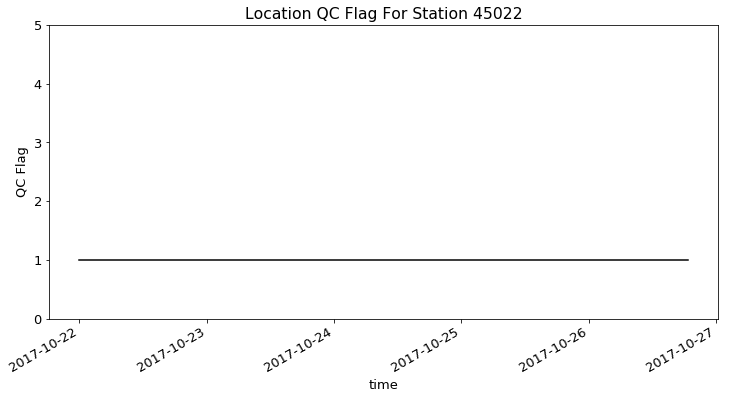

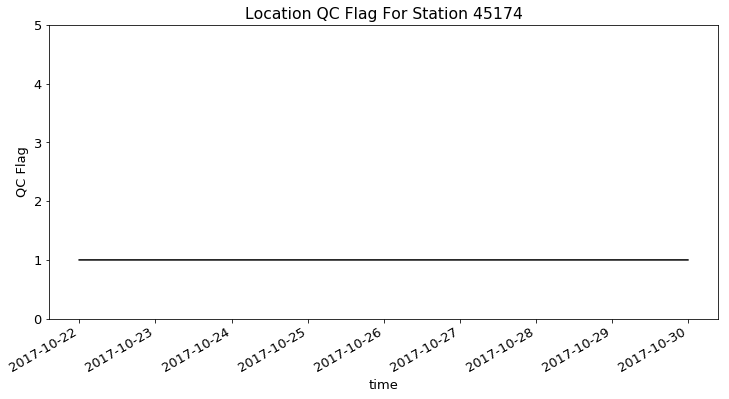

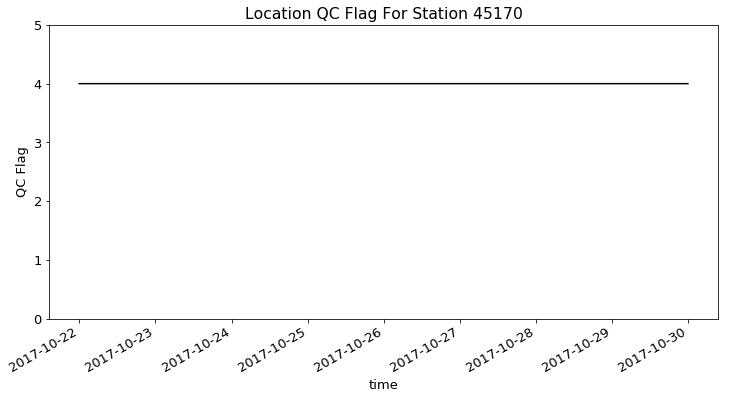

In [4]:
all_lats=[]
all_lons=[]
for station_id in station_ids:
    file_url=Glos_url+station_id+'/'+station_id+'.ncml'
    xr_dataset=xr.open_dataset(file_url)
    
    arr=xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).variables
    arr_slice=xr_dataset.sel(time=slice('2017-10-22','2017-10-29'))
    obs_df = arr_slice.to_dataframe()
    
    all_lats.append(obs_df['lat'][0])
    all_lons.append(obs_df['lon'][0])
    
    # Create a pandas dataframe to store and plot the data
    loc_flags = qc.location_set_check(arr_slice['lon'], arr_slice['lat'], bbox_arr=bbox)
    obs_df['flags'] = loc_flags

    matplotlib.rcParams.update({'font.size':13})
    fig, ax = plt.subplots(figsize=(12, 6))
    obs_df['flags'].plot(ax=ax, color='k', title='Location QC Flag For Station '+station_id, ylim=[0,5])
    ax.set_ylabel("QC Flag", fontsize=13)


### Locations Shown on a map

In [5]:
m = folium.Map(location=[45.0,0], tiles='Mapbox Bright', zoom_start=2)
folium.PolyLine(get_coordinates(np.asarray(bbox).reshape(-1)), color='#FF0000', weight=5).add_to(m)
popup_string = ('<b>Station:</b><br>'+ station_ids[1])

all_lats=np.asarray(all_lats)
all_lons=np.asarray(all_lons)

loc_flags = qc.location_set_check(all_lons, all_lats, bbox_arr=bbox, range_max=None)    

for lat, lon in zip(all_lats, all_lons):
    folium.Circle([lat, lon], color='purple', popup=popup_string).add_to(m)
bad_vals = np.where(loc_flags>1)

m


### The flagged station has positive 86.968 for longitude which could be a sign error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Gross Range test
Given sensor minimum/maximum values, flag data that falls outside of range as bad data.  Optionally also flag data which falls outside of a user defined range

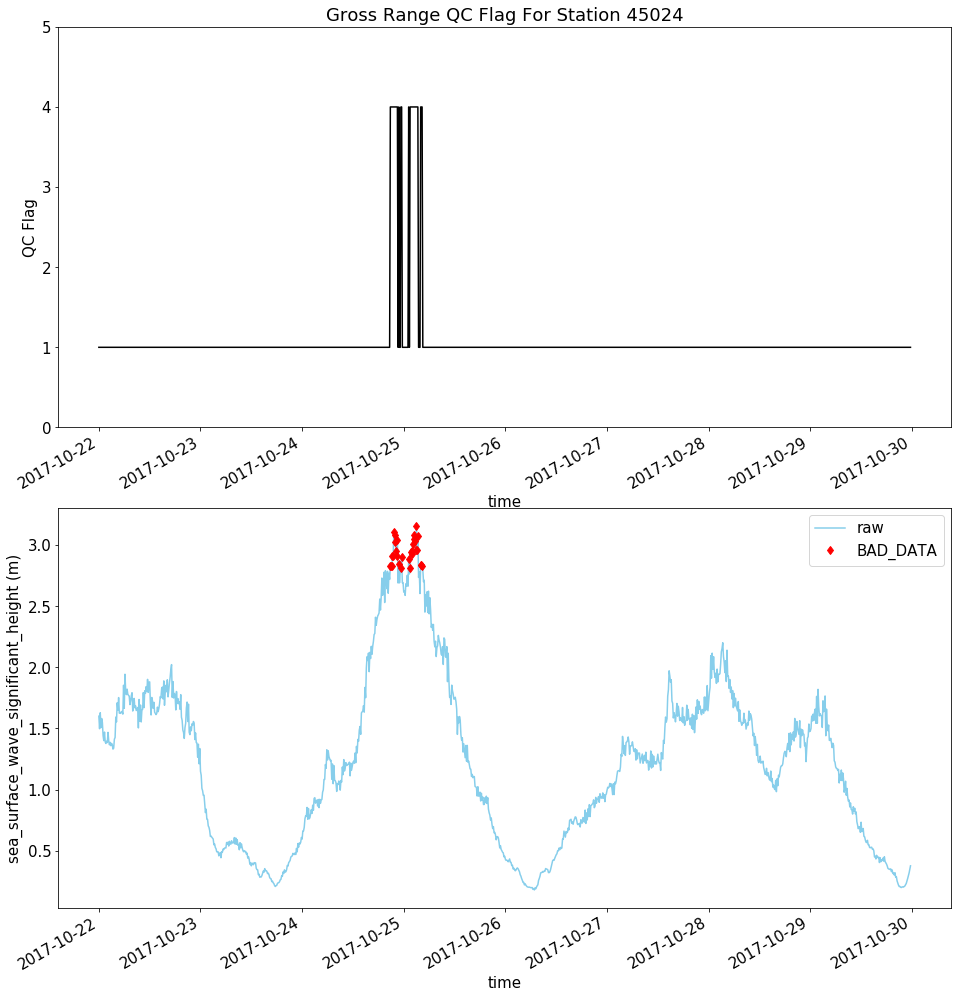

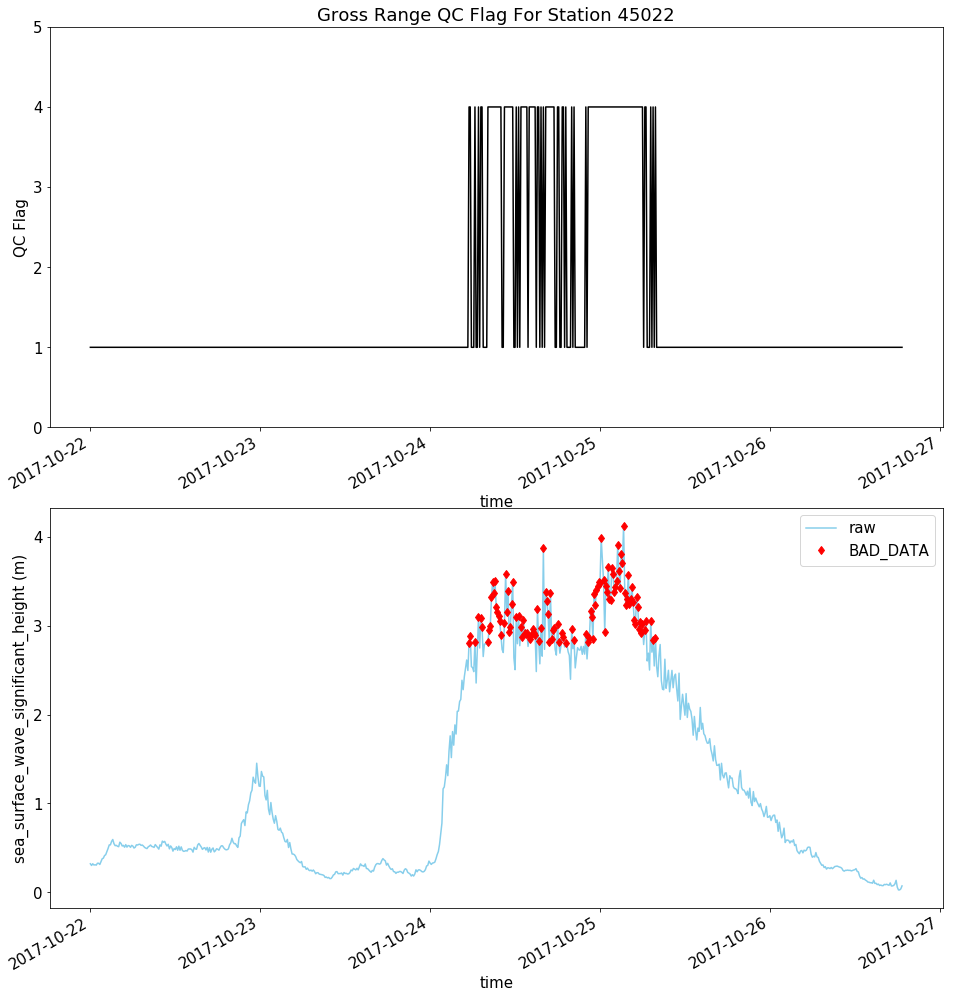

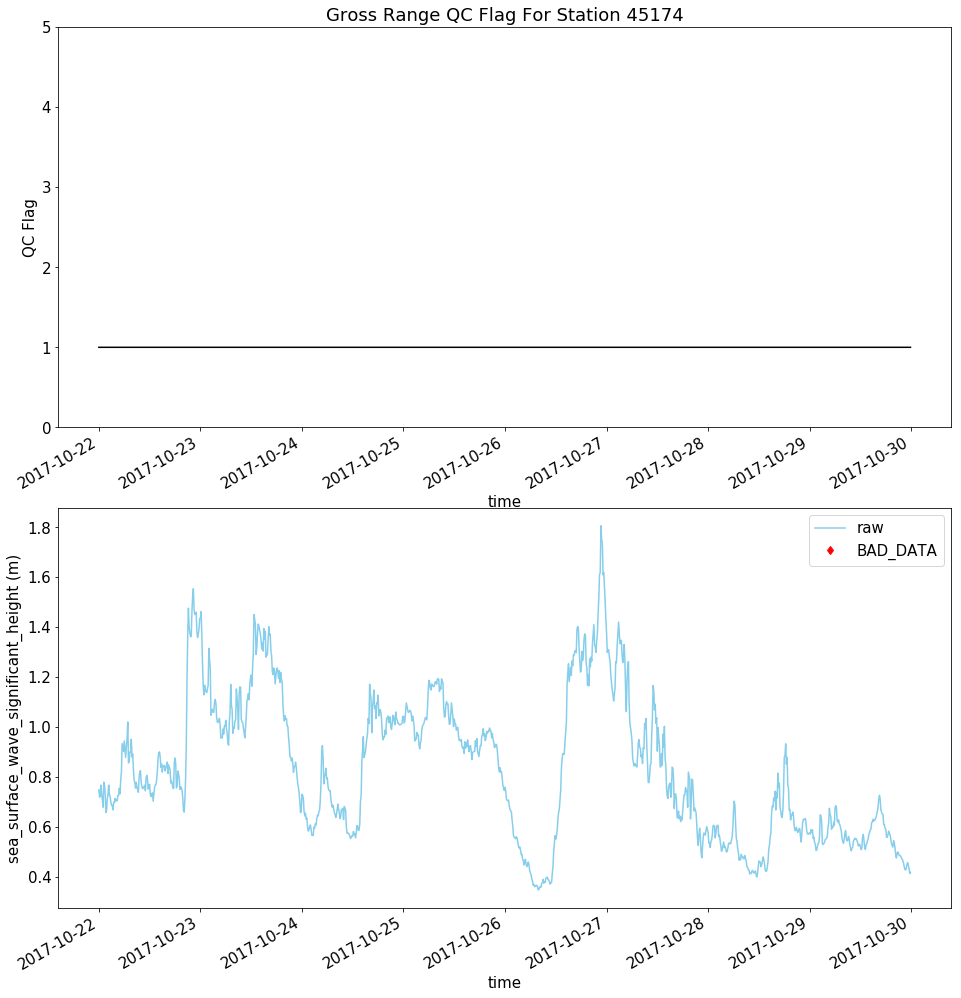

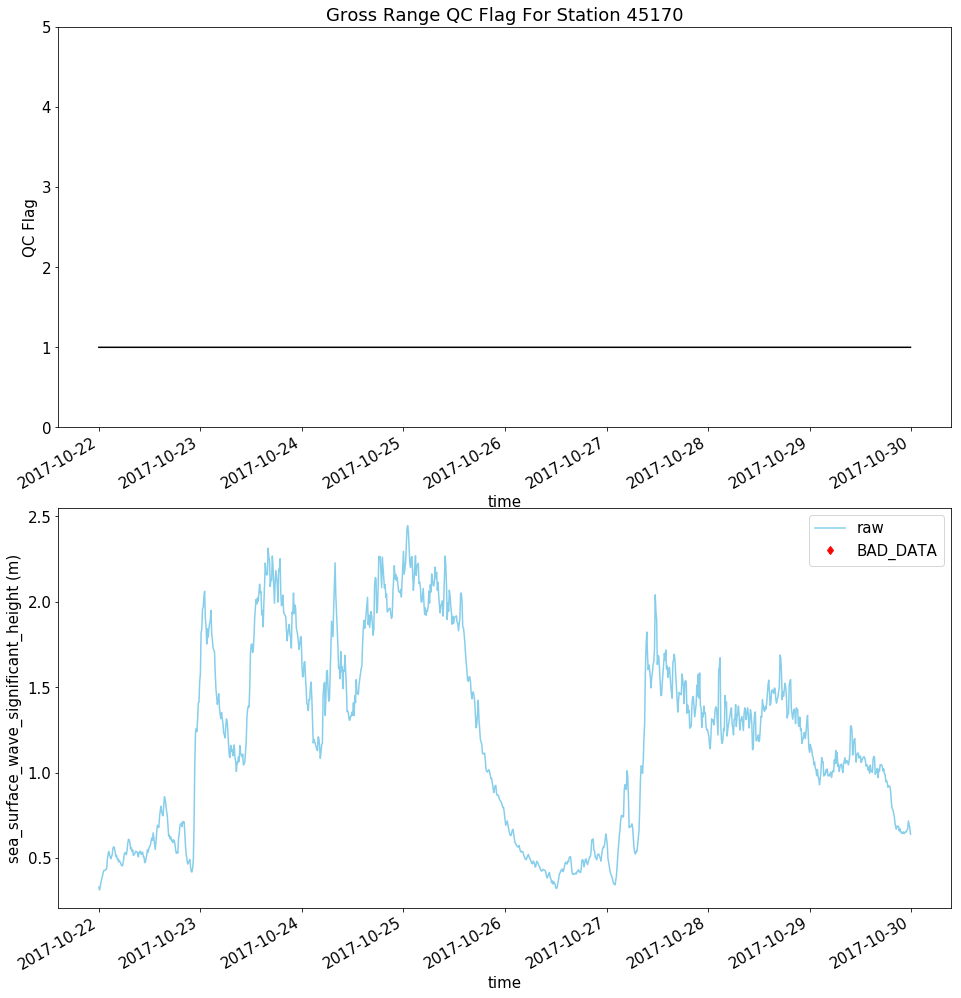

In [6]:
for station_id in station_ids:
    file_url=Glos_url+station_id+'/'+station_id+'.ncml'
    xr_dataset=xr.open_dataset(file_url)
    
    arr=xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).variables
    
    arr_slice=xr_dataset.sel(time=slice('2017-10-22','2017-10-29'))
    obs_df = xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).to_dataframe()
    

    # Specify the gross range (0-2.8m for this demonstration)
    gross_range = (0, 2.8)
    range_flags = qc.range_check(arr_slice['Significant_Wave_Height'], gross_range)
    # Create a pandas dataframe to store and plot the data

    obs_df['flags'] = range_flags
    obs_df['raw']=arr_slice['Significant_Wave_Height']
        
    matplotlib.rcParams.update({'font.size':15})
    fig, ax = plt.subplots(2,1,figsize=(16, 18))
    flags = obs_df['flags'].plot(ax=ax[0], color='k', title='Gross Range QC Flag For Station '+station_id, ylim=[0,5])
    raw = obs_df['raw'].plot(ax=ax[1], color='#87CEEB')
    flags.set_ylabel("QC Flag", fontsize=15)
    raw.set_ylabel("sea_surface_wave_significant_height (m)", fontsize=15)

    bad_data = np.where(range_flags == 4)
    
    bad_handle = ax[1].plot(arr_slice['time'][bad_data], arr_slice['Significant_Wave_Height'][bad_data], 'rd')
    plt.legend(['raw', 'BAD_DATA'])
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Spike test
Determine if there is a spike at data point n-1 by subtracting the midpoint of n and n-2 and taking the absolute value of this quantity, seeing if it exceeds a threshold for suspect and bad data. 
Values which do not exceed either threshold are flagged good, values which exceed the low threshold are flagged suspect, and values which exceed the high threshold are flagged bad. The flag is set at point n-1.

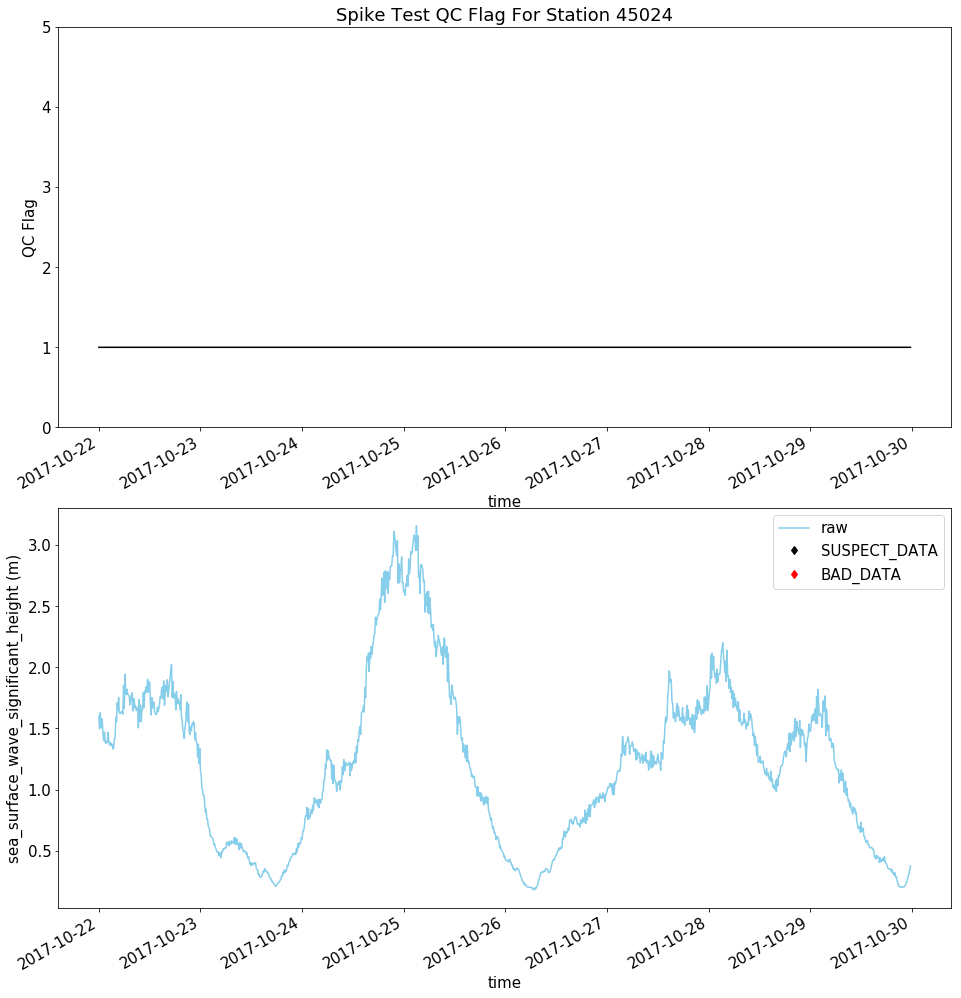

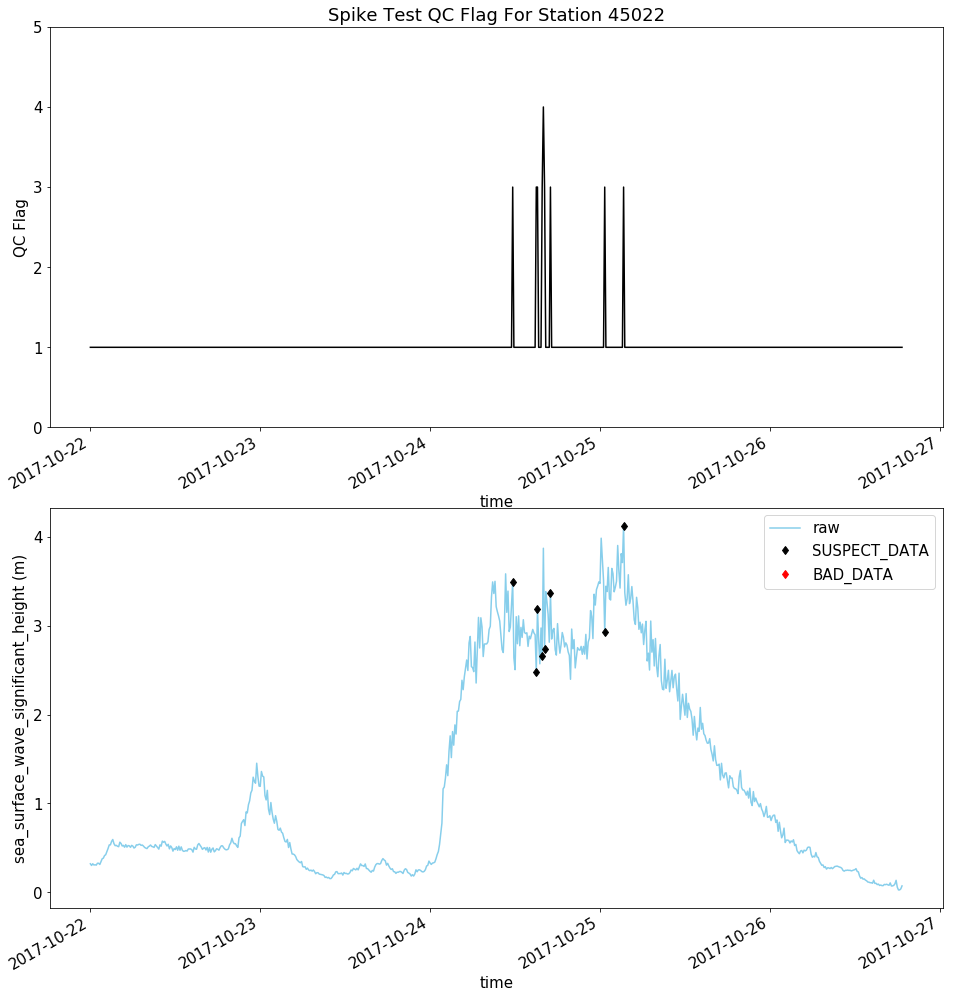

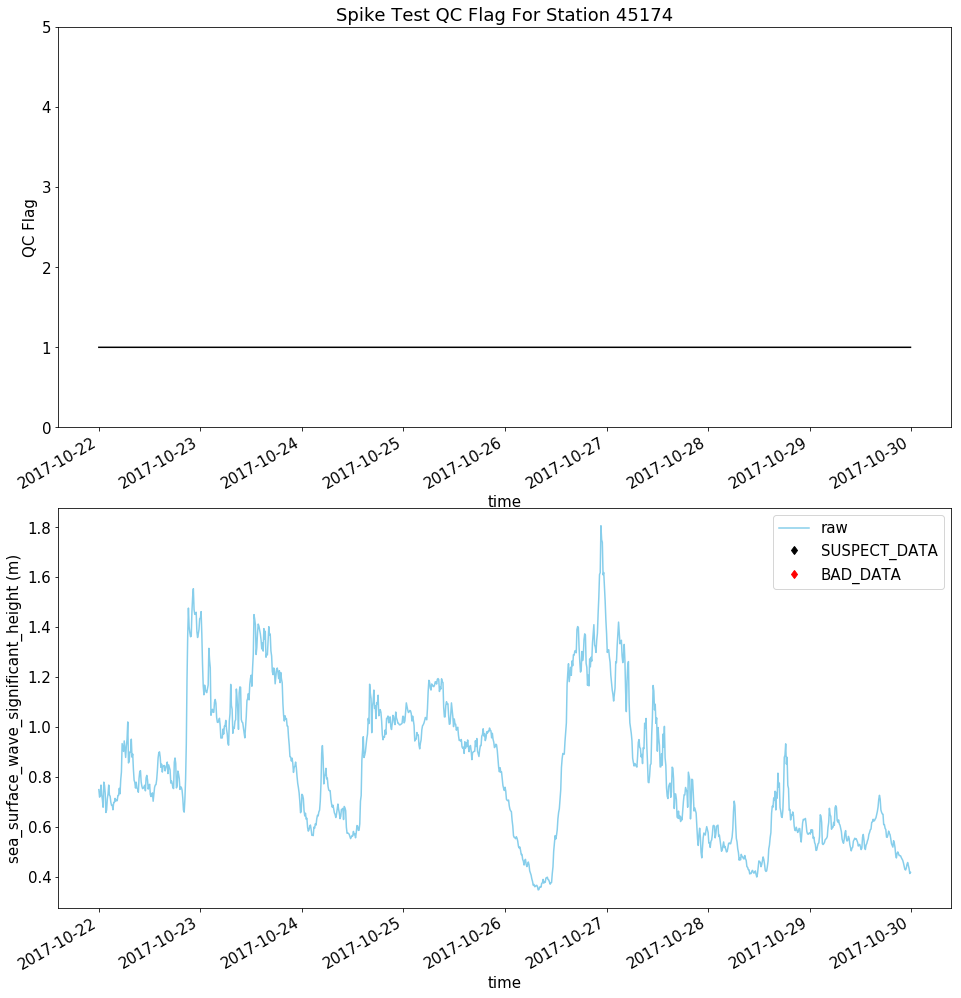

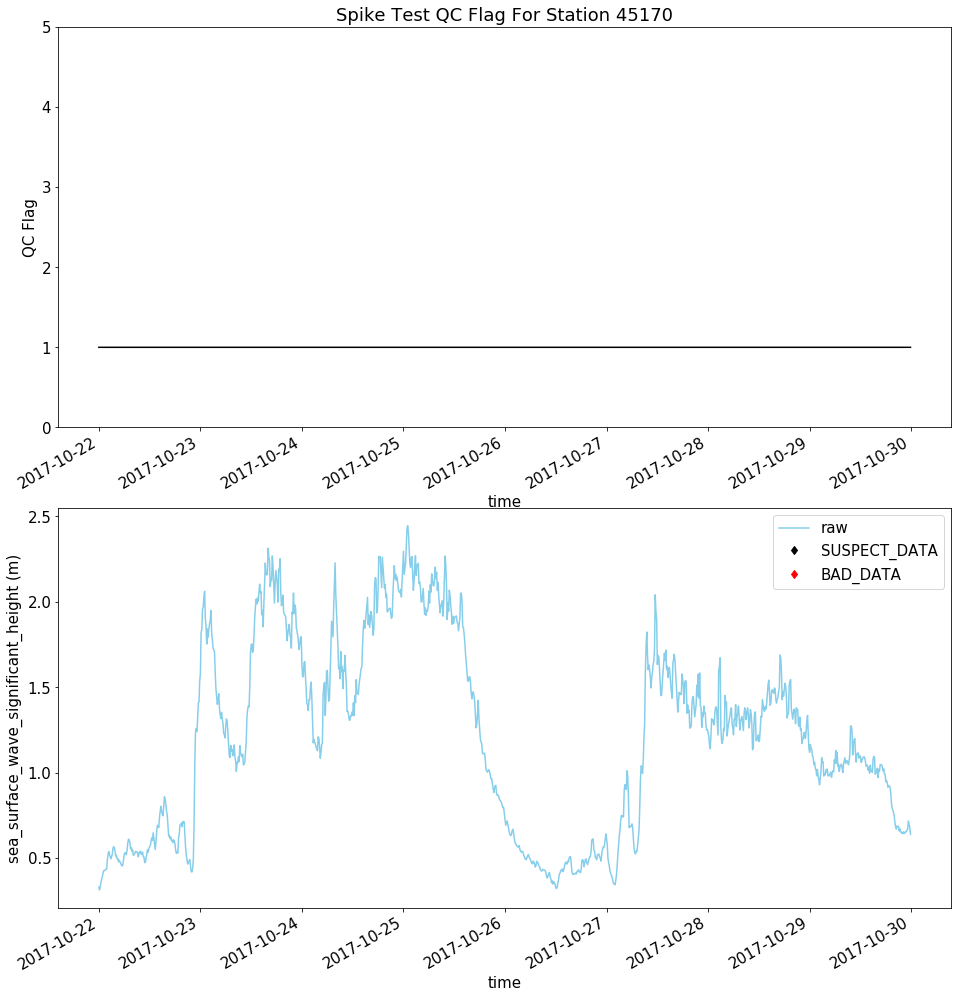

In [7]:
for station_id in station_ids:
    file_url=Glos_url+station_id+'/'+station_id+'.ncml'
    xr_dataset=xr.open_dataset(file_url)
    arr=xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).variables

    arr_slice=xr_dataset.sel(time=slice('2017-10-22','2017-10-29'))
    obs_df = xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).to_dataframe()


    warning_threshold = 0.5 #0.9144
    bad_threshold = 1 #1.524
    spike_flags = qc.spike_check(arr_slice['Significant_Wave_Height'], warning_threshold, bad_threshold)
       
    # Create a pandas dataframe to store and plot the data
    obs_df['flags'] = spike_flags
    obs_df['raw']=arr_slice['Significant_Wave_Height']

    matplotlib.rcParams.update({'font.size':15})
    fig, ax = plt.subplots(2,1,figsize=(16, 18))
    flags = obs_df['flags'].plot(ax=ax[0], color='k', title='Spike Test QC Flag For Station '+station_id, ylim=[0,5])
       
    good_data = np.where(spike_flags == 1)
    suspect_data = np.where(spike_flags == 3)
       
    raw = obs_df['raw'].plot(ax=ax[1], color='#87CEEB')
    flags.set_ylabel("QC Flag", fontsize=15)
    raw.set_ylabel("sea_surface_wave_significant_height (m)", fontsize=15)
    bad_data = np.where(range_flags == 4)
    
    #matplotlib.rcParams.update({'font.size':15})
    bad_handle = ax[1].plot(arr_slice['time'][suspect_data], arr_slice['Significant_Wave_Height'][suspect_data], 'kd')
    bad_handle = ax[1].plot(arr_slice['time'][bad_data], arr_slice['Significant_Wave_Height'][bad_data], 'rd')
    plt.legend(['raw', 'SUSPECT_DATA', 'BAD_DATA'])


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Flat Line test
Check for repeated consecutively repeated values within a tolerance eps

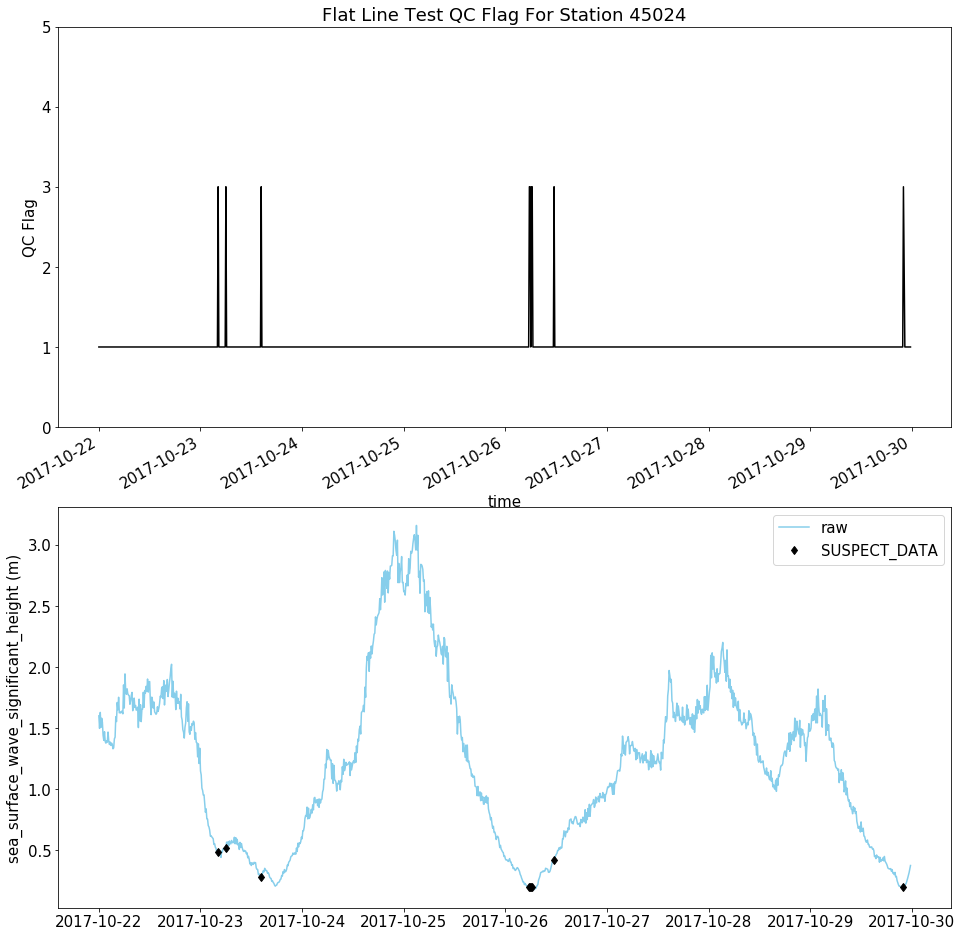

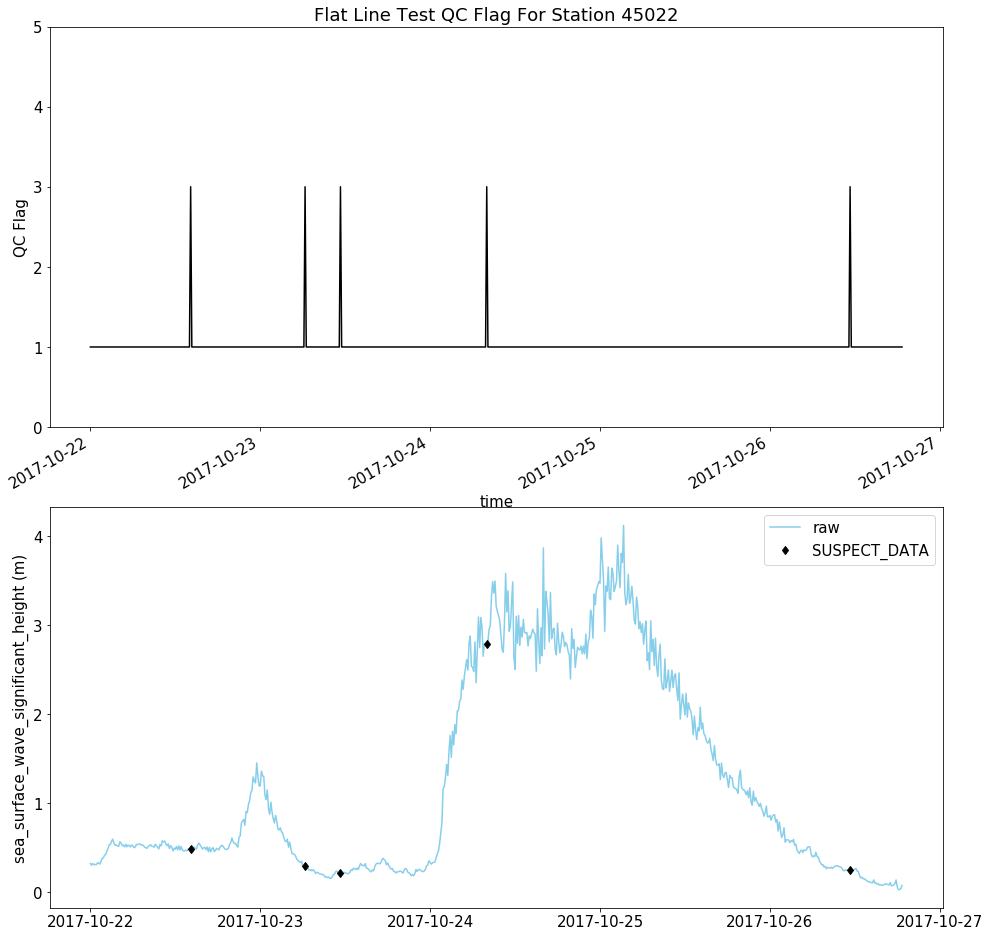

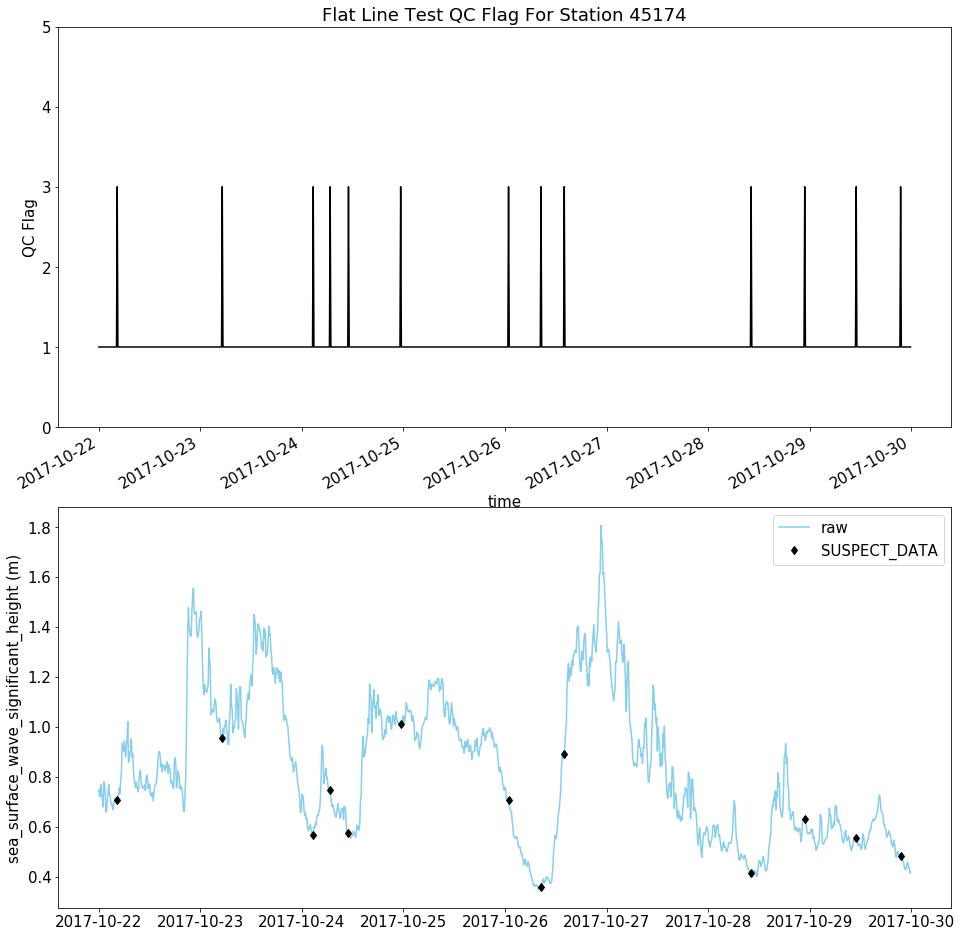

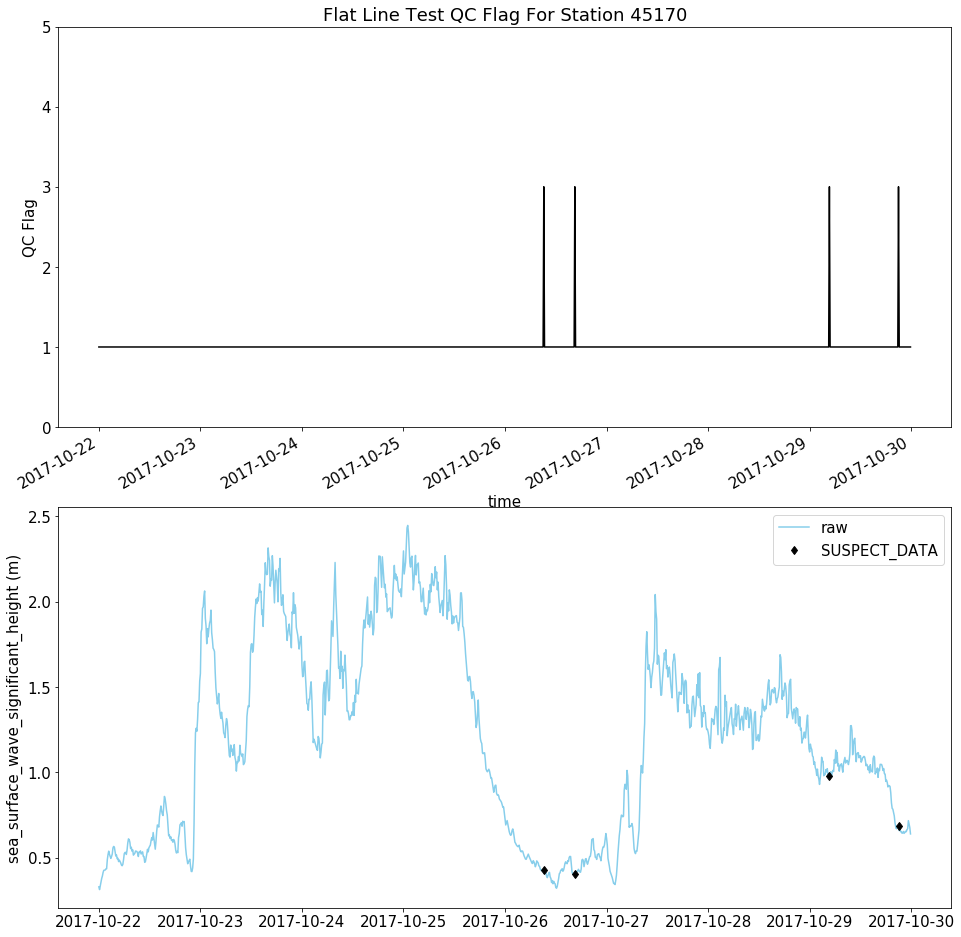

In [8]:
for station_id in station_ids:
    file_url=Glos_url+station_id+'/'+station_id+'.ncml'
    xr_dataset=xr.open_dataset(file_url)
    arr=xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).variables

    arr_slice=xr_dataset.sel(time=slice('2017-10-22','2017-10-29'))
    obs_df = xr_dataset.sel(time=slice('2017-10-22','2017-10-29')).to_dataframe()
    
    tolerance = 0.003
    rep_flags = qc.flat_line_check(arr_slice['Significant_Wave_Height'], 2, 6, tolerance)
       
    # Create a pandas dataframe to store and plot the data
    obs_df['flags'] = rep_flags
    obs_df['raw']=arr_slice['Significant_Wave_Height']

    matplotlib.rcParams.update({'font.size':15})
    fig, ax = plt.subplots(2,1,figsize=(16, 18))
    flags = obs_df['flags'].plot(ax=ax[0], color='k', title='Flat Line Test QC Flag For Station '+station_id, ylim=[0,5])
    flags.set_ylabel("QC Flag", fontsize=15)
    
    good_data = np.where(rep_flags == 1)
    bad_data = np.where(rep_flags == 4)
    suspect_data = np.where(rep_flags == 3)
    
    # Only plot the data near the suspect data to show the flat line
    ax[1].plot(arr_slice['time'], arr_slice['Significant_Wave_Height'], '#87CEEB')
    if suspect_data[0].size>0:
        ax[1].plot(arr_slice['time'][suspect_data], arr_slice['Significant_Wave_Height'][suspect_data], 'kd')
    if bad_data[0].size>0:
        ax[1].plot(arr_slice['time'][bad_data], arr_slice['Significant_Wave_Height'][bad_data], 'rd')
    
    ax[1].set_ylabel("sea_surface_wave_significant_height (m)", fontsize=15)
    plt.legend(['raw', 'SUSPECT_DATA', 'BAD_DATA'])
    plt.show()


### Flagged values are when a significant wave height changes by less than 0.003 meters between time steps
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~